# Predicting Cancer Types from Gene Expression Profiles Using Machine Learning Approaches

In [23]:
# =========================
# CELL 1 — IMPORTS & CONFIG
# =========================

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from io import StringIO

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)

try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP not installed. Run `pip install shap` if you want SHAP plots.")

RANDOM_STATE = 42

plt.style.use("default")
sns.set()

In [24]:
# ======================================
# CELL 2 — GSE2034 PIPELINE (OOP STYLE)
# ======================================

class GSE2034Pipeline:
    def __init__(self, data_path: str, random_state: int = 42):
        self.data_path = data_path
        self.random_state = random_state
        
        # Will be filled along the way
        self.lines = None
        self.df = None
        self.expr = None
        self.meta = None
        self.X_raw = None
        self.y = None
        
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.X_train_scaled = None
        self.X_test_scaled = None
        
        self.results = []       # list of dicts with metrics
        self.models = {}        # name -> fitted model
        
    # ---------- 1. LOAD DATA ----------
    def load_series_matrix(self):
        print("Loading series matrix from:", self.data_path)
        with open(self.data_path, "r") as f:
            self.lines = f.readlines()
        
        # Remove header lines for the expression table
        data_lines = [line for line in self.lines if not line.startswith("!")]
        clean_text = "".join(data_lines)
        
        self.df = pd.read_csv(StringIO(clean_text), sep="\t", index_col=0)
        print("Raw loaded shape (genes x samples):", self.df.shape)
        
        # Transpose -> samples x genes
        self.expr = self.df.T
        print("Expression shape after transpose (samples x genes):", self.expr.shape)
    
    # ---------- 2. BUILD METADATA ----------
    def build_metadata(self):
        print("\nBuilding metadata from !Sample_characteristics_ch1 ...")
        sample_ids = self.df.columns.tolist()
        n_samples = len(sample_ids)
        sample_meta = [dict() for _ in range(n_samples)]
        
        for line in self.lines:
            if not line.startswith("!Sample_characteristics_ch1"):
                continue
            
            parts = line.strip().split("\t")
            values = parts[1:]
            
            for j, v in enumerate(values):
                m = re.match(r"\s*([^:]+):\s*(.*)", v)
                if m:
                    key = m.group(1).strip()
                    value = m.group(2).strip()
                else:
                    key = f"char_{len(sample_meta[j])}"
                    value = v.strip()
                sample_meta[j][key] = value
        
        self.meta = pd.DataFrame(sample_meta, index=sample_ids)
        print("Metadata shape:", self.meta.shape)
        print("Metadata columns:", self.meta.columns.tolist())
        display(self.meta.head())
    
    # ---------- 3. CHOOSE TARGET COLUMN ----------
    def choose_target_column(self):
        """
        Automatically pick the 'bone relapses (1=yes, 0=no)' column.
        """
        print("\nChoosing target column (bone relapses) ...")
        target_col = None
        for col in self.meta.columns:
            if "bone relapses" in col.lower():
                target_col = col
                break
        
        if target_col is None:
            raise ValueError("Could not find a 'bone relapses' column in metadata.")
        
        print(f"Using target column: {target_col!r}")
        y_raw = self.meta[target_col]
        
        # clean quotes etc.
        y_clean = y_raw.astype(str).str.replace('"', '').str.strip()
        print("Unique raw target values:", y_raw.unique())
        print("Unique cleaned values:", y_clean.unique())
        
        self.y = y_clean.astype(int)
        print("Final label value counts:")
        print(self.y.value_counts())
        
        # align expression
        self.expr = self.expr.loc[self.y.index]
        self.X_raw = self.expr.copy()
        print("Aligned X_raw shape:", self.X_raw.shape)
    
    # ---------- 4. PREPROCESS ----------
    def preprocess(self, test_size: float = 0.2):
        print("\nPreprocessing: variance filter + train/test split + scaling ...")
        
        selector = VarianceThreshold(threshold=0.0)
        X_var = selector.fit_transform(self.X_raw)
        selected_genes = self.X_raw.columns[selector.get_support()]
        X_var_df = pd.DataFrame(X_var, index=self.X_raw.index, columns=selected_genes)
        
        print("After variance filter, shape:", X_var_df.shape)
        
        if X_var_df.shape[0] == 0:
            raise ValueError("No samples left after feature selection.")
        
        X_train, X_test, y_train, y_test = train_test_split(
            X_var_df,
            self.y,
            test_size=test_size,
            stratify=self.y,
            random_state=self.random_state
        )
        
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")
        
        scaler = StandardScaler()
        self.X_train_scaled = scaler.fit_transform(X_train)
        self.X_test_scaled = scaler.transform(X_test)
        
        print("Scaled train shape:", self.X_train_scaled.shape)
        print("Scaled test shape:", self.X_test_scaled.shape)
    
    # ---------- 5. EVALUATION HELPER ----------
    def _evaluate_model(self, name, model, X_train, y_train, X_test, y_test):
        model.fit(X_train, y_train)
        self.models[name] = model
        
        y_pred = model.predict(X_test)
        
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, "decision_function"):
            y_proba = model.decision_function(X_test)
        else:
            y_proba = None
        
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
        
        print(f"\n=== {name} ===")
        print("Accuracy :", acc)
        print("Precision:", prec)
        print("Recall   :", rec)
        print("F1-score :", f1)
        print("ROC-AUC  :", auc)
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, zero_division=0))
        
        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(4, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"Confusion Matrix — {name}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()
        
        # ROC curve
        if y_proba is not None:
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            plt.figure(figsize=(5, 4))
            plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")
            plt.plot([0, 1], [0, 1], linestyle="--")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"ROC Curve — {name}")
            plt.legend()
            plt.tight_layout()
            plt.show()
        
        result = {
            "model_name": name,
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "auc": auc
        }
        self.results.append(result)
    
    # ---------- 6. TRAIN MODELS ----------
    def train_all_models(self):
        print("\nTraining baseline and advanced models ...")
        
        # 1) Logistic Regression (your strong one from daaa)
        lr = LogisticRegression(
            penalty="l2",
            solver="liblinear",
            random_state=self.random_state
        )
        self._evaluate_model("Logistic Regression",
                             lr,
                             self.X_train_scaled, self.y_train,
                             self.X_test_scaled, self.y_test)
        
        # 2) Logistic Regression (class_weight balanced) - may or may not improve
        lr_bal = LogisticRegression(
            penalty="l2",
            solver="liblinear",
            class_weight="balanced",
            random_state=self.random_state
        )
        self._evaluate_model("Logistic Regression (balanced)",
                             lr_bal,
                             self.X_train_scaled, self.y_train,
                             self.X_test_scaled, self.y_test)
        
        # 3) kNN
        knn = KNeighborsClassifier(
            n_neighbors=5,
            weights="uniform"
        )
        self._evaluate_model("k-Nearest Neighbors",
                             knn,
                             self.X_train_scaled, self.y_train,
                             self.X_test_scaled, self.y_test)
        
        # 4) Random Forest (with class_weight balanced)
        rf = RandomForestClassifier(
            n_estimators=100,
            max_depth=None,
            min_samples_split=5,
            class_weight="balanced",
            random_state=self.random_state
        )
        self._evaluate_model("Random Forest",
                             rf,
                             self.X_train, self.y_train,
                             self.X_test, self.y_test)
        
        # 5) SVM (RBF) with balanced weights
        svm = SVC(
            kernel="rbf",
            C=10.0,
            gamma="scale",
            probability=True,
            class_weight="balanced",
            random_state=self.random_state
        )
        self._evaluate_model("SVM (RBF)",
                             svm,
                             self.X_train_scaled, self.y_train,
                             self.X_test_scaled, self.y_test)
        
        # 6) MLP Neural Network
        mlp = MLPClassifier(
            hidden_layer_sizes=(64, 32),
            activation="relu",
            alpha=1e-4,
            max_iter=300,
            random_state=self.random_state
        )
        self._evaluate_model("MLP Neural Network",
                             mlp,
                             self.X_train_scaled, self.y_train,
                             self.X_test_scaled, self.y_test)
    
    # ---------- 7. RESULTS SUMMARY ----------
    def get_results_df(self):
        return pd.DataFrame(self.results).sort_values(by="f1", ascending=False)
    
    # ---------- 8. RF FEATURE IMPORTANCE ----------
    def plot_rf_top_genes(self, top_n: int = 100):
        if "Random Forest" not in self.models:
            print("Random Forest model not trained.")
            return
        
        rf_model = self.models["Random Forest"]
        if not hasattr(rf_model, "feature_importances_"):
            print("Random Forest model has no feature_importances_.")
            return
        
        importances = rf_model.feature_importances_
        gene_importance = pd.Series(importances, index=self.X_train.columns)
        top_genes = gene_importance.sort_values(ascending=False).head(top_n)
        
        print("Top important genes:\n", top_genes)
        
        plt.figure(figsize=(8, 6))
        sns.barplot(x=top_genes.values, y=top_genes.index)
        plt.xlabel("Feature Importance")
        plt.ylabel("Gene")
        plt.title(f"Top {top_n} Genes — Random Forest")
        plt.tight_layout()
        plt.show()
        
        # Optionally save to CSV
        top_genes.to_csv("top_genes_rf_final.csv")
        print("Saved RF top genes → top_genes_rf_final.csv")
    
    # ---------- 9. OPTIONAL SHAP ----------
    def shap_for_rf(self, n_samples: int = 200):
        if not SHAP_AVAILABLE:
            print("SHAP not available. Install via `pip install shap`.")
            return
        
        if "Random Forest" not in self.models:
            print("Random Forest model not trained.")
            return
        
        rf_model = self.models["Random Forest"]
        X_small = self.X_train.sample(n=min(n_samples, self.X_train.shape[0]),
                                      random_state=self.random_state)
        
        explainer = shap.TreeExplainer(rf_model)
        shap_values = explainer.shap_values(X_small)
        
        print("Showing SHAP summary plot for class 1 (relapse = 1) ...")
        shap.summary_plot(shap_values[1], X_small, show=True)
    
    # ---------- 10. RUN EVERYTHING ----------
    def run(self):
        self.load_series_matrix()
        self.build_metadata()
        self.choose_target_column()
        self.preprocess()
        self.train_all_models()
        results_df = self.get_results_df()
        print("\n=== FINAL MODEL COMPARISON (sorted by F1) ===")
        display(results_df)
        return results_df

Loading series matrix from: GSE2034_series_matrix.txt
Raw loaded shape (genes x samples): (22283, 286)
Expression shape after transpose (samples x genes): (286, 22283)

Building metadata from !Sample_characteristics_ch1 ...
Metadata shape: (286, 1)
Metadata columns: ['"bone relapses (1=yes, 0=no)']


,"""bone relapses (1=yes, 0=no)"
GSM36777,"0"""
GSM36778,"0"""
GSM36779,"0"""
GSM36780,"0"""
GSM36781,"0"""



Choosing target column (bone relapses) ...
Using target column: '"bone relapses (1=yes, 0=no)'
Unique raw target values: ['0"' '1"']
Unique cleaned values: ['0' '1']
Final label value counts:
"bone relapses (1=yes, 0=no)
0    217
1     69
Name: count, dtype: int64
Aligned X_raw shape: (286, 22283)

Preprocessing: variance filter + train/test split + scaling ...
After variance filter, shape: (286, 22283)
Train size: 228, Test size: 58
Scaled train shape: (228, 22283)
Scaled test shape: (58, 22283)

Training baseline and advanced models ...

=== Logistic Regression ===
Accuracy : 0.6896551724137931
Precision: 0.42857142857142855
Recall   : 0.8571428571428571
F1-score : 0.5714285714285714
ROC-AUC  : 0.698051948051948

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.64      0.76        44
           1       0.43      0.86      0.57        14

    accuracy                           0.69        58
   macro avg       0.68      0.75

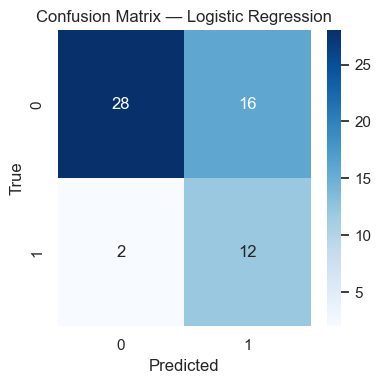

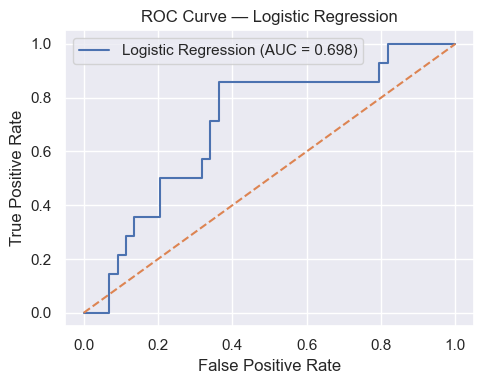


=== Logistic Regression (balanced) ===
Accuracy : 0.6724137931034483
Precision: 0.41379310344827586
Recall   : 0.8571428571428571
F1-score : 0.5581395348837209
ROC-AUC  : 0.702922077922078

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.61      0.74        44
           1       0.41      0.86      0.56        14

    accuracy                           0.67        58
   macro avg       0.67      0.74      0.65        58
weighted avg       0.81      0.67      0.70        58



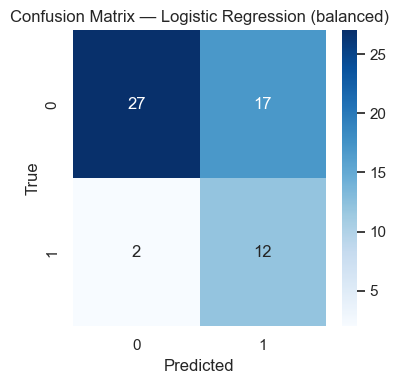

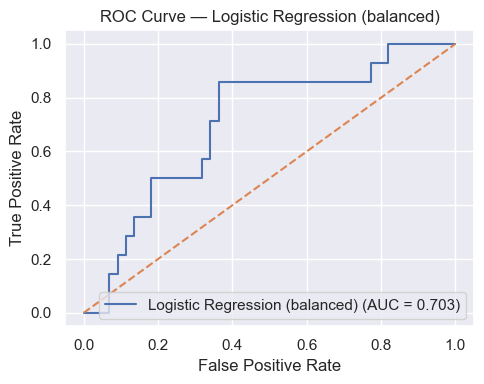


=== k-Nearest Neighbors ===
Accuracy : 0.7413793103448276
Precision: 0.4
Recall   : 0.14285714285714285
F1-score : 0.21052631578947367
ROC-AUC  : 0.6103896103896105

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.93      0.85        44
           1       0.40      0.14      0.21        14

    accuracy                           0.74        58
   macro avg       0.59      0.54      0.53        58
weighted avg       0.68      0.74      0.69        58



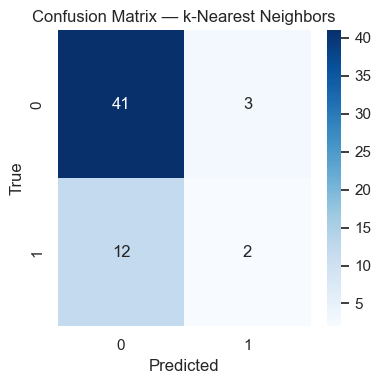

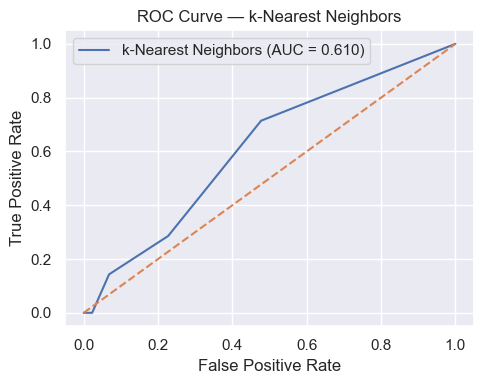


=== Random Forest ===
Accuracy : 0.7586206896551724
Precision: 0.0
Recall   : 0.0
F1-score : 0.0
ROC-AUC  : 0.6948051948051949

Classification Report:
              precision    recall  f1-score   support

           0       0.76      1.00      0.86        44
           1       0.00      0.00      0.00        14

    accuracy                           0.76        58
   macro avg       0.38      0.50      0.43        58
weighted avg       0.58      0.76      0.65        58



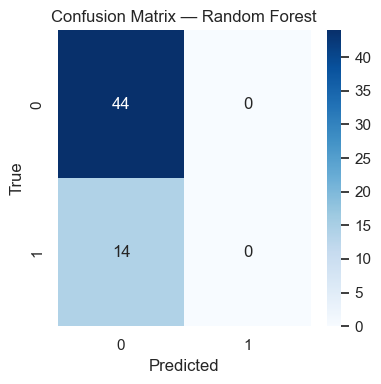

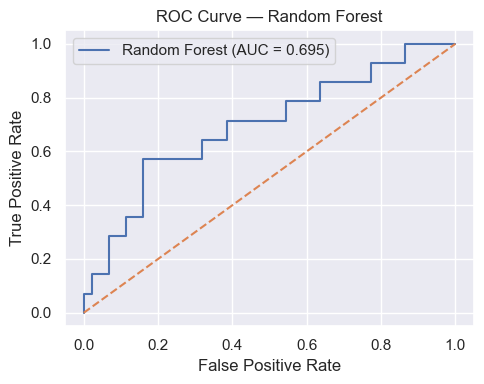


=== SVM (RBF) ===
Accuracy : 0.7413793103448276
Precision: 0.0
Recall   : 0.0
F1-score : 0.0
ROC-AUC  : 0.7288961038961039

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.98      0.85        44
           1       0.00      0.00      0.00        14

    accuracy                           0.74        58
   macro avg       0.38      0.49      0.43        58
weighted avg       0.57      0.74      0.65        58



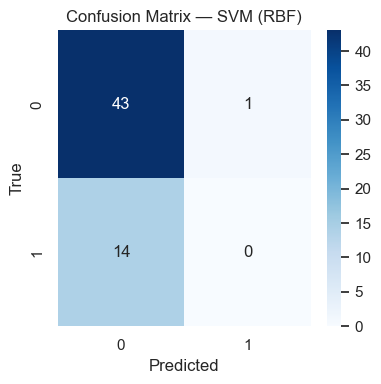

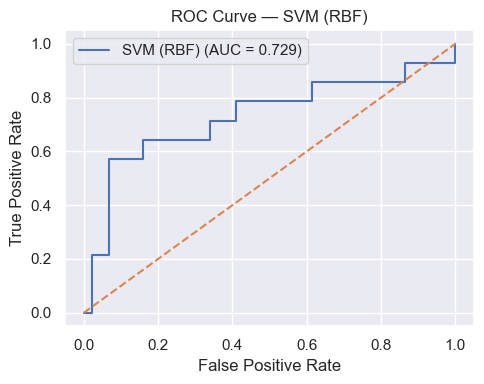


=== MLP Neural Network ===
Accuracy : 0.7413793103448276
Precision: 0.4444444444444444
Recall   : 0.2857142857142857
F1-score : 0.34782608695652173
ROC-AUC  : 0.637987012987013

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84        44
           1       0.44      0.29      0.35        14

    accuracy                           0.74        58
   macro avg       0.62      0.59      0.59        58
weighted avg       0.71      0.74      0.72        58



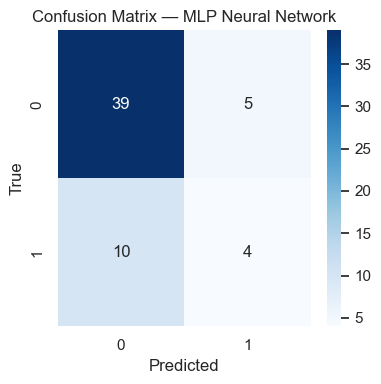

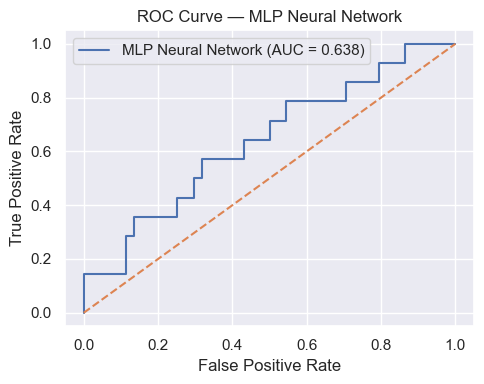


=== FINAL MODEL COMPARISON (sorted by F1) ===


,model_name,accuracy,precision,recall,f1,auc
0,Logistic Regression,0.689655,0.428571,0.857143,0.571429,0.698052
1,Logistic Regression (balanced),0.672414,0.413793,0.857143,0.558140,0.702922
5,MLP Neural Network,0.741379,0.444444,0.285714,0.347826,0.637987
2,k-Nearest Neighbors,0.741379,0.400000,0.142857,0.210526,0.610390
3,Random Forest,0.758621,0.000000,0.000000,0.000000,0.694805
4,SVM (RBF),0.741379,0.000000,0.000000,0.000000,0.728896


In [25]:
# =========================
# CELL 3 — RUN THE PIPELINE
# =========================

DATA_PATH = "GSE2034_series_matrix.txt"  # adjust if needed

pipe = GSE2034Pipeline(DATA_PATH, random_state=RANDOM_STATE)
results_df = pipe.run()

Top important genes:
 ID_REF
209835_x_at    0.006179
203331_s_at    0.005534
219197_s_at    0.004480
219596_at      0.003953
208992_s_at    0.003951
                 ...   
59999_at       0.001733
213336_at      0.001731
212257_s_at    0.001713
206997_s_at    0.001703
200008_s_at    0.001701
Length: 100, dtype: float64


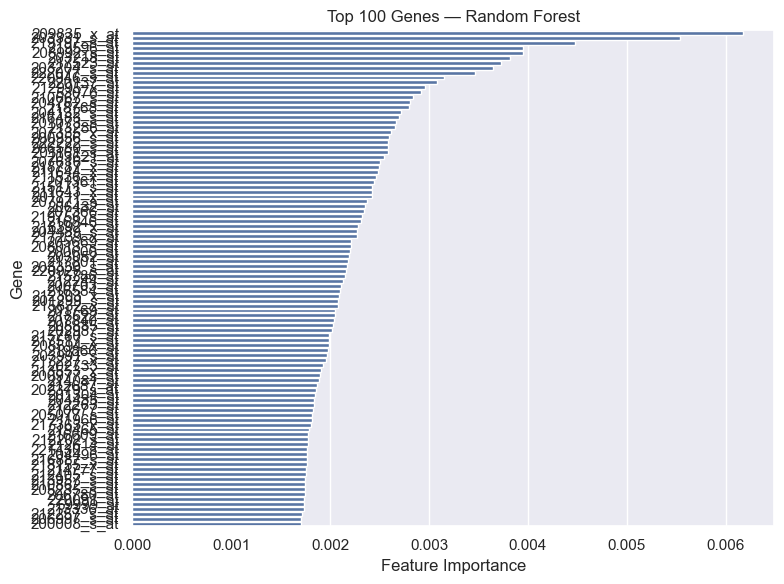

Saved RF top genes → top_genes_rf_final.csv


In [26]:
# =======================================
# CELL 4 — RF TOP GENES (FOR REPORT)
# =======================================

pipe.plot_rf_top_genes(top_n=100)

In [27]:
# ============================================
# CELL — GENE → CLASS ASSOCIATION (LOGISTIC LR)
# ============================================

import numpy as np
import pandas as pd

# 1) Get the fitted Logistic Regression model from the pipeline
best_lr = pipe.models["Logistic Regression"]  # or "Logistic Regression (balanced)" if you prefer

# 2) Coefficients and gene names
coef = best_lr.coef_[0]              # shape = (n_genes,)
genes = pipe.X_train.columns         # these are the gene names

coef_df = pd.DataFrame({
    "gene": genes,
    "coef": coef
})

# 3) Compute mean expression per class (using unscaled X_train)
X_train_df = pipe.X_train.copy()
y_train = pipe.y_train.copy()

# groupby class (0 = no relapse, 1 = relapse), then average
means_by_class = X_train_df.join(y_train).groupby(y_train.name).mean().T
means_by_class.columns = ["mean_expr_class0_no_relapse", "mean_expr_class1_relapse"]

# 4) Merge coefficient + mean expression info
merged = coef_df.set_index("gene").join(means_by_class)

# 5) Interpret direction: which class is this gene associated with?
merged["associated_with"] = np.where(
    merged["coef"] > 0,
    "relapse (class 1)",
    "no relapse (class 0)"
)

# 6) Sort by absolute size of the coefficient (most important first)
merged["abs_coef"] = merged["coef"].abs()
merged_sorted = merged.sort_values("abs_coef", ascending=False)

# 7) Show top 20 genes with their "belonging"
top_genes_lr = merged_sorted.head(100)
top_genes_lr

,coef,mean_expr_class0_no_relapse,mean_expr_class1_relapse,associated_with,abs_coef
gene,,,,,
203218_at,0.033927,776.638728,1238.952727,relapse (class 1),0.033927
222013_x_at,-0.032878,48.843931,38.825455,no relapse (class 0),0.032878
214250_at,0.032561,11.898844,23.074545,relapse (class 1),0.032561
209380_s_at,0.032029,1062.734104,1711.865455,relapse (class 1),0.032029
220618_s_at,-0.031772,74.326012,49.196364,no relapse (class 0),0.031772
...,...,...,...,...,...
213630_at,-0.023241,50.382659,40.078182,no relapse (class 0),0.023241
206326_at,0.023225,368.775723,560.343636,relapse (class 1),0.023225
208452_x_at,-0.023177,198.185549,165.392727,no relapse (class 0),0.023177


In [ ]:
# ==============================================
# CELL — FIND COMMON TOP GENES (LR vs RF)
# ==============================================

import pandas as pd
import numpy as np

# ---- 1. Get top LR genes (by absolute coefficient) ----
lr_model = pipe.models["Logistic Regression"]  # or "Logistic Regression (balanced)"
lr_coef = lr_model.coef_[0]
lr_genes = pipe.X_train.columns

lr_df = pd.DataFrame({
    "gene": lr_genes,
    "coef": lr_coef,
    "abs_coef": np.abs(lr_coef)
}).sort_values("abs_coef", ascending=False)

top_lr = lr_df.head(100)["gene"].tolist()


# ---- 2. Get top RF genes (by feature importance) ----
rf_model = pipe.models.get("Random Forest")

if rf_model is None:
    raise ValueError("Random Forest model not found in pipeline.")

rf_importances = rf_model.feature_importances_
rf_genes = pipe.X_train.columns

rf_df = pd.DataFrame({
    "gene": rf_genes,
    "importance": rf_importances
}).sort_values("importance", ascending=False)

top_rf = rf_df.head(100)["gene"].tolist()


# ---- 3. Find common genes ----
common_genes = list(set(top_lr).intersection(set(top_rf)))

# ---- 4. Print top 5 common genes ----
print("Top 100 LR genes:", top_lr)
print("Top 100 RF genes:", top_rf)
print("\nCommon genes between LR and RF:", common_genes)

# If you want only the first 5:
print("\nTop 5 common genes:")
print(common_genes[:5])

Top 20 LR genes: ['203218_at', '222013_x_at', '214250_at', '209380_s_at', '220618_s_at', '220214_at', '210570_x_at', '210030_at', '214740_at', '218778_x_at', '219756_s_at', '222085_at', '204867_at', '208434_at', '209797_at', '219193_at', '205634_x_at', '205062_x_at', '206633_at', '216185_at', '221348_at', '206549_at', '64486_at', '214277_at', '201817_at', '217928_s_at', '211338_at', '213862_at', '36936_at', '206752_s_at', '220260_at', '212617_at', '32042_at', '215297_at', '209432_s_at', '217955_at', '52164_at', '206205_at', '201764_at', '205439_at', '32088_at', '203025_at', '212129_at', '219109_at', '207190_at', '215427_s_at', '203451_at', '212133_at', '221219_s_at', '210998_s_at', '212280_x_at', '217442_at', '207786_at', '218787_x_at', '215692_s_at', '201206_s_at', '211181_x_at', '204817_at', '213910_at', '208564_at', '215866_at', '38158_at', '219758_at', '220482_s_at', '222038_s_at', '221483_s_at', '222077_s_at', '222320_at', '204055_s_at', '206396_at', '216695_s_at', '204005_s_at', 